Did you ever try to explain what embeddings are to people who have no or only a limited background in machine learning or computer science? I recently tried this in an on-the-fly attempt to explain embeddings with an analogy to animals. While I think I could get the idea across, this analogy has stuck in my mind, and here is version 2.0: Let's explore how we can visualize the embeddings of terms like "lion", "tiger", or "flamingo" to illustrate how a machine learning model understands the meaning of these terms and perceives their semantic relationships to one another.

Here is the plan:

- Let's start with a technical definition of an embedding.
- This is followed by our final visualization.
- Afterwards we'll break down the technical definition into more digestible pieces.

In the end, you will understanding exactly how the visualization was created and I hope you will have a more intuitive understanding of the underlying concepts of embeddings. If you feel that the math is to heavy, please just focus on the underpinning ideas.

## From Technical to Visualization

Here is the technical definition:

> _"In the context of machine learning and natural language processing, embeddings are numerical vector representations that capture the semantic essence of text entities, such as words, sentences, or documents. These vectors are typically high-dimensional, often consisting of hundreds or thousands of dimensions, allowing them to encode complex concepts and relationships. The fundamental idea behind embeddings is that texts with similar meanings are represented by vectors that are mathematically close to each other. This representation enables algorithms to process and analyze texts by understanding their underlying semantic content."_

Now, let's transition from theory to practice. Here are the final visualization which show how our machine learning model "thinks" about various animals, illustrating the concept of embeddings in charts that represent their semantic relationships. Why 2 charts? The left one is the more intuitive one for us humans and the right one illustrates better how the machine thinks.

![Animal Embeddings CC-BY https://creativecommons.org/licenses/by/4.0/](./animal-embeddings-combined.png)

> Notes: For readability I hidden most of the code from this blog post. The all the details, please check out the [notebook version on Github](https://github.com/chrwittm/lm-hackers/blob/main/30-rag/10-embeddings.ipynb).<br>
For readability I curated the dataset so that the animal groups are nicely separated. By reducing animals to just 2 numbers, a lot of complexity is lost, but the intent not to create a highly accurate model of the worlds, rather I wanted to present an example which is simple enough so be visualized in 2D to allow you to build some intuition on how embeddings work. Please feel free to experiment yourself in the [notebook version on Github](https://github.com/chrwittm/lm-hackers/blob/main/30-rag/10-embeddings.ipynb).



## Visualizing Embeddings with a Small Dataset

Let's start small and use a dataset with the examples of "lion", "tiger", "flamingo", and "clownfish".

### Embeddings from model

Inspired by the [hackers guide by Jeremy Howard](https://www.youtube.com/watch?v=jkrNMKz9pWU) let's use [this model](https://huggingface.co/BAAI/bge-small-en-v1.5) to calculate the embeddings via [SentenceTransformers](https://www.sbert.net)

In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Large pool of animals from the keys of animal_groups dictionary
example_animals = ["lion", "tiger", "flamingo", "clownfish"]

# Initialize your model (make sure to adjust the device according to your setup)
emb_model = SentenceTransformer("BAAI/bge-small-en-v1.5", device="cpu")

# Compute embeddings for the large pool
example_animals_embeddings = emb_model.encode(example_animals, convert_to_tensor=True).cpu().detach().numpy()

In [2]:
example_animals_embeddings.shape

(4, 384)

Each word is now represented by a 384-dimensional vector. What does this mean, and where do these numbers come from?

## Training an Embedding Model

The model we use is [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5). BAAI stands for "[Beijing Academy of Artificial Intelligence](https://www.baai.ac.cn/english.html)". Is a private non-profit organization known for its research and development in artificial intelligence technologies. BGE stands for "[BAAI general embedding](https://huggingface.co/BAAI/bge-small-en-v1.5#model-list)".

Diving into [theit GitHub repo](https://github.com/FlagOpen/FlagEmbedding), we can read that this model has been trained in English (and there are Chinese and multi-language models available). It is a [general embedding model](https://github.com/FlagOpen/FlagEmbedding?tab=readme-ov-file#bge-embedding) which has been pre-trained using [RetroMAE](https://github.com/staoxiao/RetroMAE). Subsequently, it has been trained on large-scale pair data using contrastive learning.

In the [RetroMAE](https://arxiv.org/abs/2205.12035) pre-training phase, the model has been exposed to vast amounts of text data, such as Wikipedia and BookCorpus to learn a wide range of language patterns, contextual relationships, and the nuances of semantics without specific task-oriented guidance. [Contrastive learning](https://de.wikipedia.org/wiki/Kontrastives_Lernen) has taught the model to pull the embeddings of texts that are similar (positive pairs) closer to each other and push apart embeddings of texts that are dissimilar (negative pairs). It's through these methods that the model learns to understand and encode the semantic essence of texts into vectors.

Essentially, an embedding is a numerical representation of a text. Unlike [hashes](https://en.wikipedia.org/wiki/Hash_function), which primarily aim at crating unique representations of stings for retrieval or data integrity, embeddings are designed to capture semantic meaning and relationships between pieces of text. As we will see, embeddings of "lion" and "tiger" are mathematically more similar to each other than "tiger" and "flamingo", capturing their semantic meaning and similarity.


## What is Dimensionality Reduction?

Trying to understand how these 384 dimensions can describe a single word is impossible beyond the trust that these number can magically describe our 4 animals. To gain a more intuitive understanding of embeddings, we can reduce this high-dimensional space to something more manageable, like two dimensions. You can think of this as projecting an object with a torch to the wall, the 3D object is projected to 2D. However, it is important to do the projection in a way which preserves important information. Check out to the following visualization [@visualizevalue](https://twitter.com/visualizevalue) to the the potential problem.

![Projection](projection-truth-inverted.png)

One effective algorithm for dimensionality reduction is [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) which simplifies the data while preserving its most significant patterns.

> Note: The remainder of this section explains how PCA works. If you prefer to focus on the results, feel free to skip ahead.

PCA transforms the original high-dimensional variables into a new set of lower dimensional variables, the principal components, which capture the maximum variance in the data. Therefore, the data's variability is preserved as much as possible. As a result, noise is reduced without filtering out essential information, making it easier to observe patterns, clusters, or relationships that were not apparent in the higher-dimensional space.

Since the math was not 100% self-explanatory to me, I created a separate [deep-dive notebook exploring PCA](https://github.com/chrwittm/lm-hackers/blob/main/30-rag/15-reduce%20dimensionality.ipynb) which reduces the dimensionality of a 3D-dataset to 2D, including interactive visualizations. Here is the executive summary which visually takes you through the process:

![PCA Steps](pca-steps.png)

- **Figure 1:** This is out example dataset with 10 samples of 3D points
- **Figure 2:** The 2 vectors are the principal components (PC1 and PC2) capturing the maximum variance in the data. We construct a plane from the 2 vectors, the projection plane.
- **Figure 3:** The 3D-points are projected onto the principal components plane.    
- **Figure 4:** The projected points on the plane in 3D space
- **Figure 5:** The projected points rotated in a way that we can see the 2D projection in 3D space from above, simulating the reduced dimensionality
- **Figure 6:** The final 2D representation of the data

With a clear understanding of dimensionality reduction, we can now apply PCA to our example dataset containing "lion," "tiger," "flamingo," and "clownfish" and visualize the outcome.

## Applying Dimensionality Reduction

Sklearn offers an easy to consume implementation to apply PCA to out example dataset.

In [3]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
example_animals_embeddings_2d = pca.fit_transform(example_animals_embeddings)

Here is the result, both numerically and plotted in 2D.

In [4]:
example_animals_embeddings_2d

array([[-0.35093537, -0.07018732],
       [-0.4075373 ,  0.02734617],
       [ 0.3408063 ,  0.40827572],
       [ 0.41766608, -0.3654344 ]], dtype=float32)

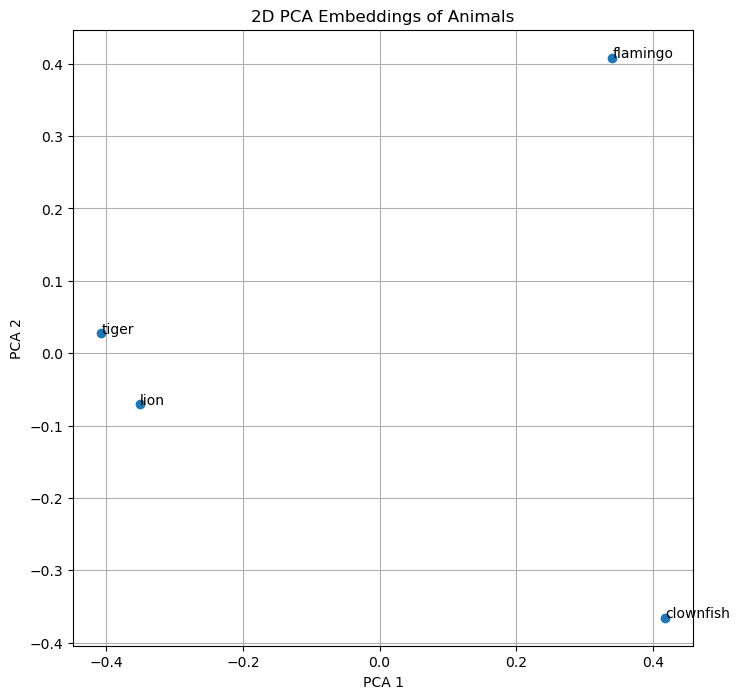

In [5]:
#|echo: false
import matplotlib.pyplot as plt

# Plotting the 2D embeddings
plt.figure(figsize=(8, 8))

# Scatter plot of the embeddings
plt.scatter(example_animals_embeddings_2d[:, 0], example_animals_embeddings_2d[:, 1])

# Annotating the points with the animal names
for i, label in enumerate(example_animals):
    plt.text(example_animals_embeddings_2d[i, 0], example_animals_embeddings_2d[i, 1], label)

plt.title('2D PCA Embeddings of Animals')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

As we can easily see, "lion" and "tiger" are closer to ech other then "tiger" and "flamingo". After the first visual "proof" let's explore how we can calculate the distance mathematically because this is how the machine evaluates the similarity of text.

## Calculating Distance

What we intuitively do when looking at the chart above is to calculate the so-called [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). We see that "lion" and "tiger" are close to each other while the other dots are farther away. While we will do a quick implementation for calculating the Euclidean distances in the next sub-section, it turns out, however, that there are better ways to calculate similarity between vectors. This is why subsequently, we will dive into calculating [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), followed by a discussion on why cosine similarity is better for calculating the similarity between 2 vectors.

### Calculating Euclidean Distance

Here is a visualization of the euclidean distances for our example dataset, confirming our observations.

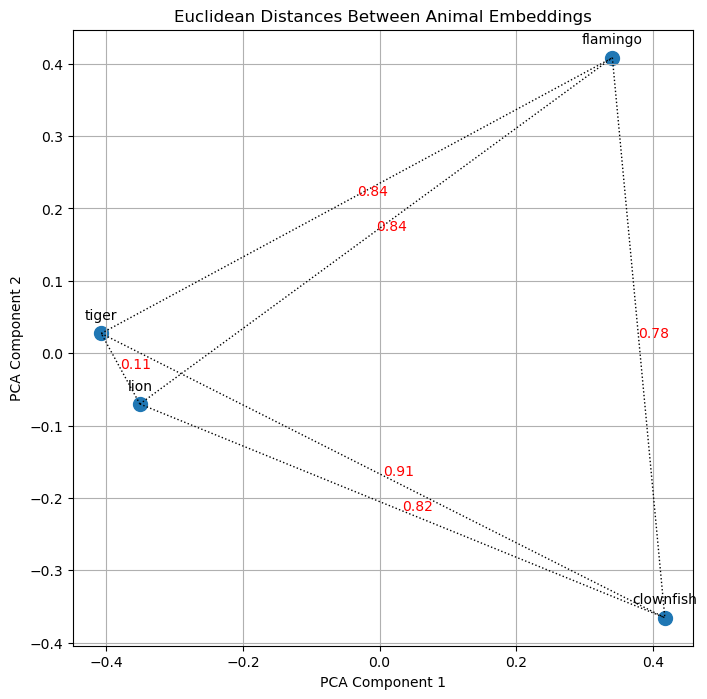

In [6]:
#|echo: false
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# Function to plot the points and annotate distances
def plot_with_distances(embeddings, labels):
    plt.figure(figsize=(8, 8))
    
    # Plot the points
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=100)
    
    # Annotate points with labels
    for i, label in enumerate(labels):
        plt.annotate(label, (embeddings[i, 0], embeddings[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')
    
    # Draw dotted lines and annotate distances
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            # Compute the Euclidean distance
            distance = euclidean(embeddings[i], embeddings[j])
            
            # Draw a dotted line between points
            plt.plot([embeddings[i, 0], embeddings[j, 0]], [embeddings[i, 1], embeddings[j, 1]], 'k:', linewidth=1)
            
            # Calculate midpoint for the distance label
            mid_point = (embeddings[i] + embeddings[j]) / 2
            
            # Annotate the line with distance
            plt.text(mid_point[0], mid_point[1], f'{distance:.2f}', color='red')
    
    plt.title('Euclidean Distances Between Animal Embeddings')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()

# Call the function with your data
plot_with_distances(example_animals_embeddings_2d, example_animals)

It is also possible to do this calculation in higher dimensionality, but as we discussed above, the orientation of the vectors is more significant than their magnitude. Therefore, let's turn our attention to cosine similarity.

### Calculating Cosine Similarity

Cosine similarity focuses on the orientation of the vectors with respect to each other without considering their magnitudes (lengths). It measures the similarity between two vectors as the cosine of the angle between them. Vectors pointing in the same direction (regardless of their length) have a cosine similarity of 1, indicating they are very similar. Vectors at 90 degrees to each other have a cosine similarity of 0, indicating no similarity, and vectors pointing in opposite directions have a cosine similarity of -1, indicating completely dissimilar. This principle holds true in higher-dimensional spaces as well. For instance, two vectors in a 3D space will adhere to the same value range for their cosine similarity. Hence, this measure can effectively express the similarity between vectors across any number of dimensions, focusing on how vectors are oriented with respect to each other rather than how far apart they are. This relation is plotted in the following cosine graph, which is colored to indicate similarity. 

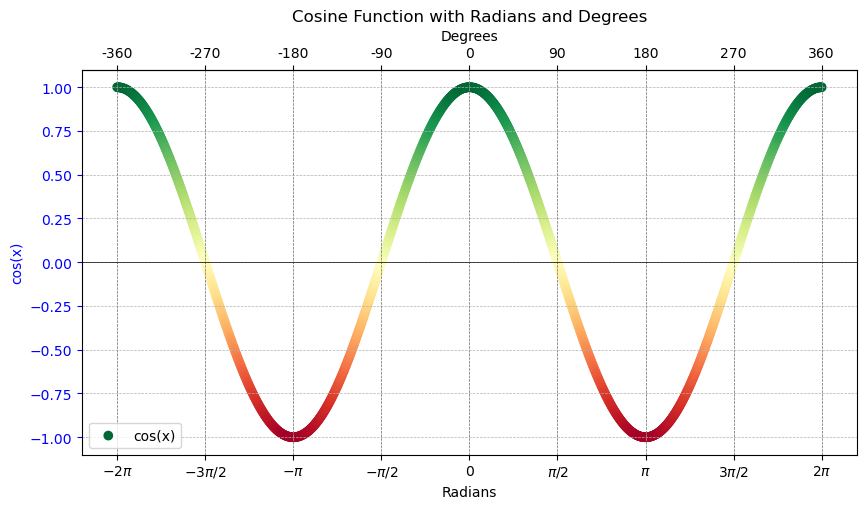

In [7]:
#|echo: false
import matplotlib.pyplot as plt
import numpy as np

# Define the range of values for x in radians from -2pi to 2pi
x_radians = np.linspace(-2 * np.pi, 2 * np.pi, 1000)

# Calculate the cosine of each x value
y = np.cos(x_radians)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 5))  # Set figure size and get primary axis
cmap = plt.get_cmap('RdYlGn')  # Get the colormap

# Plot x vs. cos(x) on primary axis with color mapping
color_mapped_y = np.interp(y, (y.min(), y.max()), (0, 1))  # Normalize y for color mapping
ax1.scatter(x_radians, y, c=color_mapped_y, cmap=cmap, label='cos(x)')

# Set primary x-axis (radians) ticks and labels
radian_ticks = np.arange(-2 * np.pi, 2.5 * np.pi, np.pi / 2)
radian_labels = ['$-2\pi$', '$-3\pi/2$', '$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
ax1.set_xticks(radian_ticks)
ax1.set_xticklabels(radian_labels)
ax1.set_xlabel('Radians')

# Set y-axis label
ax1.set_ylabel('cos(x)', color='b')
ax1.tick_params('y', colors='b')

# Define conversion functions for radians to degrees and vice versa
def rad2deg(r):
    return r * 180 / np.pi

# Create secondary x-axis for degrees
degree_ticks = radian_ticks * 180 / np.pi
ax2 = ax1.secondary_xaxis('top', functions=(rad2deg, np.deg2rad))
ax2.set_xticks(degree_ticks)
ax2.set_xticklabels([f"{tick:.0f}" for tick in degree_ticks])
ax2.set_xlabel('Degrees')

# Add vertical helper lines at multiples of π/2
for tick in radian_ticks:
    ax1.axvline(tick, color='gray', linestyle='--', linewidth=0.5)

# Additional customizations
ax1.axhline(0, color='black', linewidth=0.5)  # Draw a horizontal line at y=0
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a grid
ax1.legend()  # Add legend
plt.title('Cosine Function with Radians and Degrees')  # Title of the plot

# Show the plot
plt.show()


Let's transfer this our animal example. When thinking in terms of cosine similarity, we need to plot our 4 animals differently. Each animal is represented as vectors, and the magnitude of the vectors are normalized. Additionally, starting with the flamingo, the cosine of the angle in relation to "flamingo" is colored to indicate similarity. 

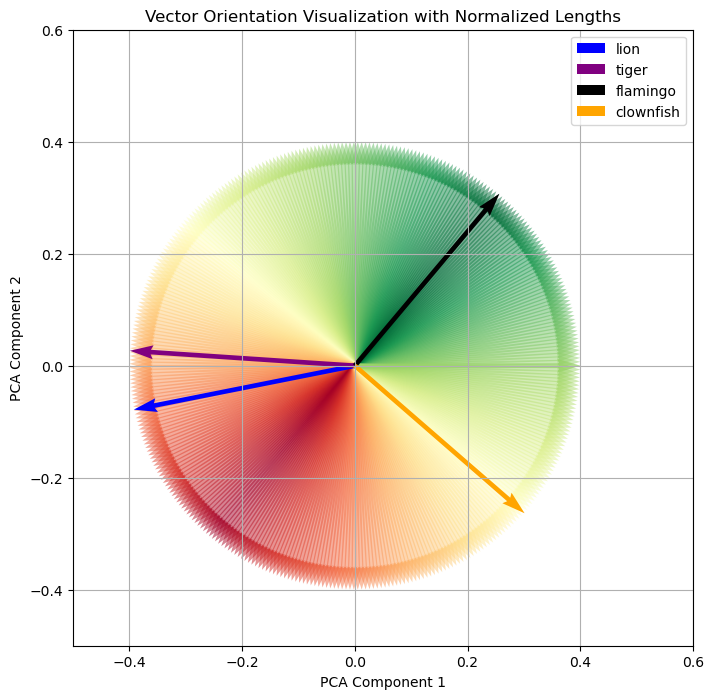

In [8]:
#|echo: false
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Assuming 'example_animals_embeddings_2d' contains your PCA-transformed embeddings
animals = ["lion", "tiger", "flamingo", "clownfish"]
animal_vectors = {animal: example_animals_embeddings_2d[animals.index(animal)] for animal in animals}

# Normalize each vector to have a length of 0.4
normalized_animal_vectors = {animal: (vector / np.linalg.norm(vector)) * 0.4 for animal, vector in animal_vectors.items()}

# Colors for each vector that is neither green nor red
vector_colors = {'lion': 'blue', 'tiger': 'purple', 'flamingo': 'black', 'clownfish': 'orange'}

# Plotting setup
plt.figure(figsize=(8, 8))
norm = Normalize(vmin=0, vmax=180)
cmap = plt.get_cmap('RdYlGn')  # Red to Green color map
sm = ScalarMappable(norm=norm, cmap=cmap)

# Generate and plot additional vectors with colors based on their angle to the flamingo vector
vector_flamingo = normalized_animal_vectors['flamingo']  # Use the normalized flamingo vector
for angle in np.linspace(0, 2*np.pi, 360):
    x, y = np.cos(angle) * 0.4, np.sin(angle) * 0.4  # Vectors of length 0.4
    angle_deg = np.degrees(angle)
    angle_to_flamingo = np.degrees(np.arctan2(vector_flamingo[1], vector_flamingo[0]))  # Angle of the flamingo vector
    diff_angle = np.abs((angle_deg - angle_to_flamingo + 180) % 360 - 180)  # Difference in angle
    color = sm.to_rgba(180 - diff_angle)  # Determine color based on difference in angle
    plt.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=color, alpha=0.5)

# Plot the normalized animal vectors
for animal, vector in normalized_animal_vectors.items():
    plt.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color=vector_colors[animal], label=animal)

# Adjust plot limits and labels
plt.xlim(-0.5, 0.6)
plt.ylim(-0.5, 0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend()
plt.title('Vector Orientation Visualization with Normalized Lengths')

plt.show()

### Euclidean Distance vs. Cosine Similarity

When comparing Euclidean distance and cosine similarity, it's important to consider various aspects that highlight the strengths and limitations of each measure in different contexts. Cosine similarity often proves to be superior in capturing the essence of similarity between vectors, especially in high-dimensional spaces, and offers computational advantages as well.

One reason cosine similarity is favored over Euclidean distance is due to the "[curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)": As the number of dimensions increases, data becomes sparse, making all points seem far from each other in the vast volume of high-dimensional space. Consider our example with 4 data points: They can be close together in 2 dimensions, but in a 384-dimensional space, the volume expands exponentially with the dimensions, making the points appear far apart. In 2 dimensions, they can easily be plotted in a relatively small space. In 3D-space, the volume of the cube is the length to the power of 3. In a 384-dimensional space, the volume is the length to the power of 384 - incomprehensible, but it sounds huge! Cosine similarity addresses this by measuring the orientation or directionality of vectors rather than their Euclidean distance, effectively mitigating the impact of dimensionality.

Computationally, cosine similarity benefits from being calculated through dot products (matrix multiplication), which can be efficiently parallelized, offering performance benefits compared to the computations required for Euclidean distance.

Moreover, cosine similarity inherently normalizes its output to a fixed range of -1 to 1, regardless of input magnitude. This normalization makes it easier to compare similarity scores across different contexts, unlike Euclidean distance, which can vary widely in magnitude and makes direct comparisons less intuitive. This bounded range of cosine similarity scores is particularly advantageous, providing a straightforward method to assess relative similarity between pairs of vectors. Furthermore, the -1 to 1 value range aligns well with neural network architectures, optimizing the data input, even though cosine similarity calculations are primarily utilized during inference.


## Visualizing Embeddings with More Data

I hope, I did not loose you along the way. Things have gotten a bit technical, but now we are in a good position to create a more complex example which we can nonetheless intuitively understand.

Let's consider the following data for visualization: 

In [9]:
group_colors = {
    "Cats": 'red',
    "Birds": 'orange',
    "Insects": 'brown',
    "Fish": 'cyan'
}

# Dictionary mapping of animals to their corresponding groups
animal_groups = {
    "cat": "Cats", "tiger": "Cats", "lion": "Cats", "bobcat": "Cats", "jaguar": "Cats", "leopard": "Cats", "lynx": "Cats", "cougar": "Cats",
    "bird": "Birds", "sparrow": "Birds", "raven": "Birds", "eagle": "Birds", "crow": "Birds", "dove": "Birds", "penguin": "Birds", "flamingo": "Birds", "owl": "Birds", "hawk": "Birds",
    "ant": "Insects", "beetle": "Insects", "spider": "Insects", "butterfly": "Insects", "bee": "Insects", "wasp": "Insects", "dragonfly": "Insects", "ladybug": "Insects",
    "goldfish": "Fish", "trout": "Fish", "salmon": "Fish", "clownfish": "Fish", "tuna": "Fish", "mackerel": "Fish"
}

Same as above, we calculate the embeddings using the [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5) model, and we reduce the dimensionality via [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).

In [10]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Large pool of animals from the keys of animal_groups dictionary
large_pool_texts = list(animal_groups.keys())

# Initialize your model (make sure to adjust the device according to your setup)
emb_model = SentenceTransformer("BAAI/bge-small-en-v1.5", device="cpu")

# Compute embeddings for the large pool
large_pool_embeddings = emb_model.encode(large_pool_texts, convert_to_tensor=True).cpu().detach().numpy()

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
large_pool_embeddings_2d = pca.fit_transform(large_pool_embeddings)

# Store the 2D embeddings in a dictionary, indexed by animal name
embeddings_2d_dict = {animal: large_pool_embeddings_2d[i] for i, animal in enumerate(large_pool_texts)}

Let's draw the Euclidean distance first by creating clusters of animals. It is important to clarify that these clusters were formed based on the predefined dataset rather than being algorithmically mined from the data. This was a deliberate choice to show that the embedding model has effectively learned to how to group animals. These fairly abstract concepts of "cat", "bird" or "insect" are connoted in the embeddings, and we can see this because the model converts the strings "lion", "flamingo" or "ant" into numerical representations which still contain semantic meaning. Creating the embedding therefore is not just a string-to-number conversion (like calculating a hash). It is a lot more nuanced transformation, and it is amazing to see that the embeddings even retain their semantic meaning after we have reduced their dimensionality to only 2 dimensions.

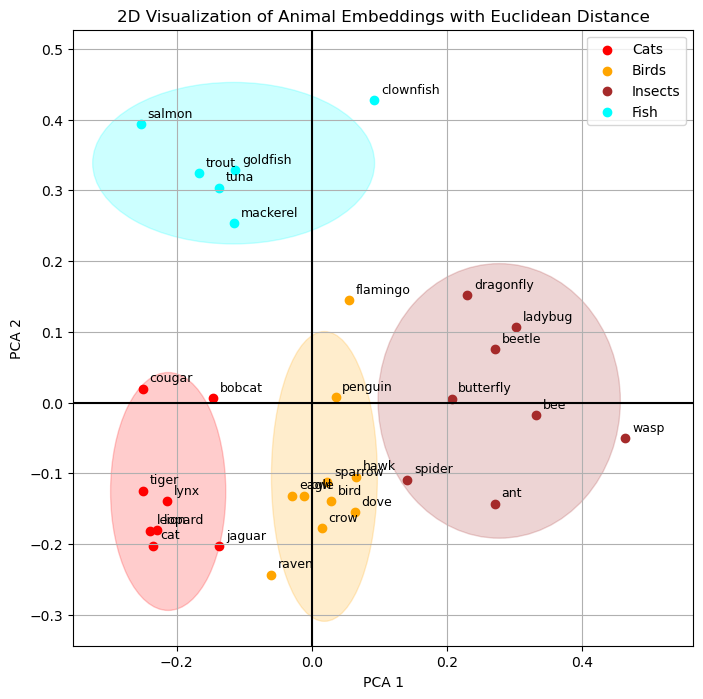

In [12]:
#|echo: false
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.patches as patches

# Setup the plot
fig, ax = plt.subplots(figsize=(8, 8))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D Visualization of Animal Embeddings with Euclidean Distance')

# Assuming large_pool_texts, embeddings_2d_dict, group_colors, and animal_groups are defined elsewhere in your notebook

# Calculate the bounds for the plot
all_embeddings = np.array([embeddings_2d_dict[animal] for animal in embeddings_2d_dict])
x_min, x_max = all_embeddings[:, 0].min() - 0.1, all_embeddings[:, 0].max() + 0.1
y_min, y_max = all_embeddings[:, 1].min() - 0.1, all_embeddings[:, 1].max() + 0.1

# Set the axes limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add grid
plt.grid(True)

# Draw the origin
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

# Pre-plotting for legend purposes
for group, color in group_colors.items():
    ax.scatter([], [], color=color, label=group)

# Loop through animals_to_visualize and plot each
for animal in animals_to_visualize:
    group = animal_groups[animal]
    color = group_colors[group]
    embedding_2d = embeddings_2d_dict[animal]
    ax.scatter(embedding_2d[0], embedding_2d[1], color=color)
    ax.text(embedding_2d[0]+0.01, embedding_2d[1]+0.01, animal, fontsize=9)

# Draw transparent bubbles for each group
for group, color in group_colors.items():
    group_embeddings = np.array([embeddings_2d_dict[animal] for animal in animal_groups if animal_groups[animal] == group])
    if len(group_embeddings) > 0:
        centroid = np.mean(group_embeddings, axis=0)
        std_dev = np.std(group_embeddings, axis=0)
        ellipse = patches.Ellipse((centroid[0], centroid[1]), std_dev[0]*4, std_dev[1]*4, color=color, alpha=0.2)
        ax.add_patch(ellipse)

# Display the full legend
ax.legend()

# Show the plot
plt.show()

Finally, let's turn to the cosine similarity, which is the way the machine can even better work with similarity. Personally, I find the Euclidean distance more intuitive in 2D, but thinking back to the comparison of the 2 mechanism, I can also appreciate that the cosine similarity is more universals and computationally more effective. Nonetheless, we can see a similar pattern when plotting the cosine similarities.

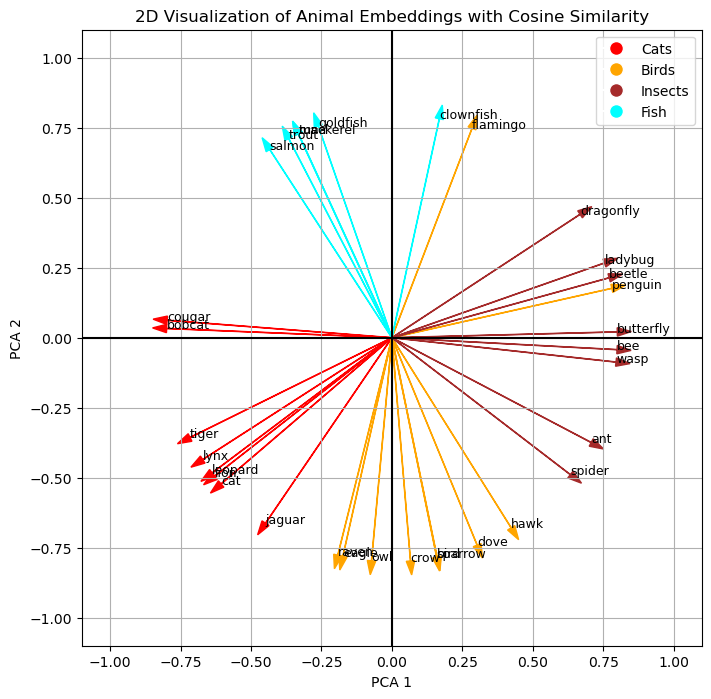

In [21]:
#|echo: false
import matplotlib.pyplot as plt
import numpy as np

# Assuming embeddings_2d_dict and group_colors are defined as in your data preparation

fig, ax = plt.subplots(figsize=(8, 8))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('2D Visualization of Animal Embeddings with Cosine Similarity')

# Set limits for the plot based on the normalized vectors
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

# Add grid
plt.grid(True)

# Draw the origin
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

# Normalize vectors and plot
for animal, embedding in embeddings_2d_dict.items():
    # Normalize the vector to have a fixed length
    norm = np.linalg.norm(embedding)
    if norm == 0:   # To avoid division by zero
        continue
    normalized_vector = embedding / norm

    # Calculate direction for the vector
    dx = normalized_vector[0]
    dy = normalized_vector[1]

    # Fixed length for all vectors
    length = 0.8

    # Set color based on the animal group
    group = animal_groups[animal]
    color = group_colors[group]

    # Plot vector
    ax.arrow(0, 0, dx*length, dy*length, head_width=0.03, head_length=0.05, fc=color, ec=color)

    # Add text label
    ax.text(dx*length, dy*length, animal, fontsize=9)

# Display the full legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=group,
                          markerfacecolor=color, markersize=10)
                   for group, color in group_colors.items()]
ax.legend(handles=legend_elements)

plt.show()

## Conclusion

In this blog post, we have explored the foundational principles of embeddings and brought them to life through visualization. Let's revisit the technical definition of an embedding from the beginning, its meaning should be much clearer now:

> _"In the context of machine learning and natural language processing, embeddings are numerical vector representations that capture the semantic essence of text entities, such as words, sentences, or documents. These vectors are typically high-dimensional, often consisting of hundreds or thousands of dimensions, allowing them to encode complex concepts and relationships. The fundamental idea behind embeddings is that texts with similar meanings are represented by vectors that are mathematically close to each other. This representation enables algorithms to process and analyze texts by understanding their underlying semantic content."_

We have seen how embeddings are numerical representations of text, in the example we used numerical representations of animals ("lion", "tiger", "flamingo", "clownfish" etc.) which contain semantic information. We have reduced the dimensionality of the vectors with 384 dimensions to only 2 dimensions to plot the 2D vectors. We have visually seen that the semantic information of the data remained intact even in the reduced vectors because the points representing the animals formed the clusters of the dataset ("Cats", "Birds", "Insects", "Fish") we did not show to the embedding model. This proximity of the points (their Euclidean distance) represents their semantic relation to each other. Finally, we discussed and plotted the cosine similarly which has advantages for calculating vector similarity in machine learning use cases.

In closing, regardless of how complex the math might seem, I hope you have gained a more intuitive understanding of embeddings and the underlying concepts they are built upon. 